# Classification

## Objectives

*   Fit and evaluate a classification model to predict if a prospect will churn or not.


## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [30]:
import os 

project_root = "/workspaces/milestone-project-heritage-housing-issues"
os.chdir(project_root)

print("Current working directory set to:")
print(os.getcwd())

Current working directory set to:
/workspaces/milestone-project-heritage-housing-issues


---

# Step 1: Load Data

In [39]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/house_prices_cleaned.csv")
      .drop(labels=['EnclosedPorch', 'WoodDeckSF'], axis=1)  
  )

print(df.shape)
df.head(3)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


---

# Step 2: ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

In [40]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()


Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [41]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base


Custom Class for Hyperparameter Optimisation

In [42]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


## Split Train and Test Set

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1168, 21) (1168,) (292, 21) (292,)


## Handle Target Imbalance

In [52]:
# Check for missing values per column
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

# Show the columns that have missing values and how many
print("Columns with missing values:\n")
print(missing_counts)

Columns with missing values:

Series([], dtype: int64)


In [ ]:
# Identify and convert categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

# Also include any known categorical columns that might be read as float (e.g., ordinal categories)
additional_categoricals = ['GarageFinish', 'BsmtExposure', 'KitchenQual', 'BsmtFinType1'] 
for col in additional_categoricals:
    if col in X_train.columns:
        categorical_cols.append(col)

# Remove duplicates
categorical_cols = list(set(categorical_cols))

# Convert dtype
X_train[categorical_cols] = X_train[categorical_cols].astype('category')
X_test[categorical_cols] = X_test[categorical_cols].astype('category')

In [54]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 17) (1168,) (292, 17) (292,)


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is 

Check Train Set Target distribution

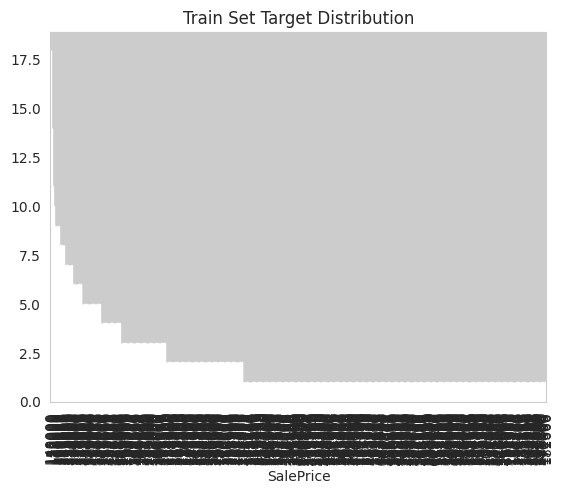

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [57]:
print(y_train.value_counts())

SalePrice
140000    18
135000    14
155000    11
130000    10
115000     9
          ..
466500     1
172400     1
76000      1
171500     1
182000     1
Name: count, Length: 573, dtype: int64


In [56]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 6

Check Train Set Target distribution after resampling

In [ ]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm 

In [58]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}


Quick GridSearch CV - Binary Classifier

In [59]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/feature_selection/_from_model.py", line 358, in fit
    self.estimator_.fit(X, y, **fit_params)
  File "/home/cistudent/.local/lib/python3.12/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502], got [ 34900  37900  39300  40000  52500  55000  55993  60000  61000  64500
  66500  67000  72500  73000  75500  76500  78000  79000  79900  80000
  80500  81000  82000  83000  83500  84000  84500  85000  85400  85500
  86000  87000  88000  89000  89500  90000  91000  91300  91500  92000
  93000  93500  94000  94500  94750  95000  96500  97000  98000  98300
  98600  99500 100000 101800 102000 103000 103200 103600 104900 105000
 105500 106000 107000 107500 108000 108500 109000 109008 109500 109900
 110000 110500 111000 111250 112000 113000 114500 114504 115000 116000
 116500 116900 117000 117500 118000 118400 118500 118858 118964 119000
 119500 119750 120000 120500 121000 121600 122000 122500 122900 123000
 123500 124000 124500 124900 125000 125500 126000 126175 126500 127000
 127500 128000 128500 128900 128950 129000 129500 129900 130000 130250
 130500 131000 131500 132000 132250 132500 133000 133700 133900 134000
 134432 134500 134800 134900 135000 135500 135750 135960 136500 136900
 137000 137450 137500 138000 138500 138800 139000 139400 139600 139950
 140000 140200 141000 141500 142000 142125 142500 142600 143000 143250
 143500 143750 144000 144152 144900 145000 145250 146000 146500 146800
 147000 147400 147500 148000 148500 149000 149300 149500 149700 149900
 150000 150750 150900 151000 151500 152000 153000 153337 153500 153575
 153900 154000 154300 154500 154900 155000 155835 156000 157000 157500
 157900 158000 158900 159000 159500 160000 160200 161000 161500 161750
 162000 162500 162900 163000 163500 163990 164000 164500 164700 165000
 165150 165400 165500 166000 167000 167240 167500 167900 168000 168500
 169000 169500 169990 170000 171000 171500 171750 171900 172000 172400
 172500 172785 173000 173500 173733 173900 174000 174500 174900 175000
 175500 176000 176432 176485 176500 177000 178000 178400 178740 179000
 179200 179400 179500 179665 179900 180000 180500 181000 181134 182000
 183200 183500 184000 184750 185000 185500 185750 185850 186500 186700
 187000 187100 187500 188000 188700 189000 189950 190000 191000 192000
 192500 193000 194000 194500 194700 195000 195400 196000 196500 197000
 197500 197900 198900 199900 200000 200100 201000 202500 202900 203000
 204000 204750 204900 205000 205950 206000 207000 207500 208300 208500
 208900 210000 211000 212000 212900 213000 213500 214000 215000 215200
 216000 216500 217000 217500 218000 219210 219500 220000 221000 221500
 222000 222500 223000 224000 224900 225000 226000 227000 227680 227875
 228000 228500 228950 229000 230000 231500 232000 232600 233170 233230
 234000 235000 235128 236000 236500 237000 237500 238000 239000 239500
 239686 240000 241000 241500 242000 244000 244400 244600 245500 248000
 248328 250000 250580 252000 253000 253293 254000 254900 255000 255500
 255900 256000 256300 257500 258000 259000 259500 260000 261500 262000
 262500 263435 264132 264561 265900 265979 266500 267000 268000 269500
 269790 270000 271000 271900 272000 274000 274300 274725 274900 274970
 275000 275500 277000 278000 280000 281213 283463 285000 287000 289000
 290000 293077 294000 295000 295493 297000 299800 301500 302000 303477
 305000 305900 309000 310000 311500 312500 315000 315500 315750 317000
 318000 318061 319000 320000 325000 325300 326000 328900 333168 335000
 336000 337000 337500 339750 340000 341000 342643 345000 348000 350000
 354000 359100 360000 361919 369900 372402 374000 375000 377426 377500
 380000 381000 383970 394432 394617 395000 395192 402861 410000 423000
 424870 426000 430000 437154 440000 451950 466500 485000 501837 556581
 582933 611657 625000]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/feature_selection/_from_model.py", line 358, in fit
    self.estimator_.fit(X, y, **fit_params)
  File "/home/cistudent/.local/lib/python3.12/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506], got [ 34900  35311  37900  39300  40000  52000  55000  55993  58500  60000
  61000  62383  64500  66500  67000  68400  72500  73000  75000  75500
  76000  78000  79000  79900  80000  81000  83000  83500  84500  85000
  85400  85500  86000  87000  88000  89000  89500  90000  91000  91300
  91500  92000  93000  93500  94000  94500  95000  96500  97000  97500
  98000  98300  98600  99500 100000 101800 102000 102776 103000 103600
 104900 105000 105500 106000 106500 107000 107400 107500 108000 108480
 109000 109008 109500 109900 110000 110500 111000 111250 112000 112500
 113000 114500 114504 115000 116000 117000 117500 118000 118400 118500
 118964 119000 119500 119900 120000 120500 121500 121600 122000 122500
 122900 123000 123500 124000 124500 124900 125000 125500 126000 126175
 126500 127000 127500 128000 128500 128900 128950 129000 129500 129900
 130000 130250 130500 131000 131400 131500 132000 132250 132500 133000
 133500 133700 133900 134000 134432 134500 134800 134900 135000 135500
 135900 135960 136500 136900 137000 137500 138000 138500 138800 138887
 139000 139400 139900 139950 140000 141000 142000 142125 142500 142600
 143000 143250 143500 143900 144000 144500 144900 145000 145250 146000
 147000 147400 147500 148000 148500 149000 149300 149500 149700 149900
 150000 150750 150900 151000 151400 151500 152000 153000 153337 153500
 153575 153900 154000 154500 154900 155000 155835 156000 156932 157000
 157500 157900 158000 159000 159434 159500 159895 159950 160000 161000
 161500 161750 162000 163000 163500 163990 164000 164500 164700 164900
 165000 165150 165500 166000 167000 167240 167500 167900 168000 168500
 169000 169500 169900 169990 170000 171000 171750 171900 172400 172500
 173000 173500 173733 173900 174000 174500 174900 175000 175500 176000
 176485 176500 177000 177500 178000 178740 179000 179200 179400 179500
 179540 179600 179665 179900 180000 180500 181000 181134 182000 183000
 183500 184000 184100 184750 184900 185000 185500 185750 185850 186500
 186700 187000 187500 188000 188700 189000 189950 190000 191000 192000
 192140 192500 193000 194000 194500 194700 195000 195400 196000 196500
 197000 197500 197900 198900 199900 200000 200141 201000 201800 202500
 202900 203000 204000 204750 205000 205950 206000 206900 207000 207500
 208300 208900 209500 210000 211000 212000 212900 213500 214000 214500
 214900 215000 216000 216500 217000 217500 218000 219210 219500 220000
 221000 221500 222000 222500 223000 223500 224000 224900 225000 226000
 226700 227000 227680 227875 228000 228500 228950 229000 230000 231500
 232000 232600 233170 233230 234000 235000 235128 236000 236500 237000
 239000 239500 239686 239799 240000 241000 241500 242000 244000 244400
 244600 245000 246578 248000 248328 250000 250580 252000 252678 253293
 254000 254900 255000 255500 256000 256300 257000 257500 258000 259000
 259500 260000 260400 261500 262000 262280 262500 263435 264561 265900
 265979 266000 266500 267000 268000 269500 269790 270000 271000 271900
 272000 274000 274300 274725 274900 274970 275000 275500 276000 277000
 278000 279500 280000 281000 281213 284000 285000 286000 287000 287090
 289000 290000 293077 294000 295000 295493 297000 299800 301500 302000
 305000 307000 309000 310000 311500 311872 314813 315000 315500 315750
 318000 318061 320000 325000 325300 325624 326000 328000 328900 335000
 336000 337500 339750 340000 341000 342643 345000 350000 354000 360000
 361919 369900 374000 375000 377426 377500 378500 381000 383970 392500
 394432 395192 402000 410000 423000 424870 426000 437154 440000 446261
 465000 466500 475000 485000 501837 611657 755000]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/feature_selection/_from_model.py", line 358, in fit
    self.estimator_.fit(X, y, **fit_params)
  File "/home/cistudent/.local/lib/python3.12/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499], got [ 35311  39300  40000  52000  52500  55000  55993  58500  60000  61000
  62383  68400  72500  73000  75000  75500  76000  76500  78000  79000
  79900  80000  80500  81000  82000  83000  83500  84000  84500  85000
  85400  85500  86000  87000  88000  89500  90000  91000  91300  91500
  92000  93000  93500  94000  94500  94750  95000  96500  97000  97500
  98000  98600  99500 100000 101800 102000 102776 103000 103200 103600
 104900 105000 106000 106500 107000 107400 107500 108000 108480 108500
 109000 109008 109500 109900 110000 110500 111000 111250 112000 112500
 113000 114500 114504 115000 116000 116500 116900 117000 117500 118000
 118500 118858 118964 119000 119500 119750 119900 120000 120500 121000
 121500 121600 122000 122500 123000 123500 124000 124500 124900 125000
 125500 126000 126175 127000 127500 128000 128500 128900 129000 129500
 129900 130000 130250 130500 131000 131400 131500 132000 132250 132500
 133000 133500 133700 133900 134000 134500 134900 135000 135500 135750
 135900 135960 136500 136900 137000 137450 137500 138000 138500 138800
 138887 139000 139400 139600 139900 139950 140000 140200 141000 141500
 142000 142125 142500 142600 143000 143250 143500 143750 143900 144000
 144152 144500 144900 145000 145250 146000 146500 146800 147000 147400
 147500 148000 148500 149000 149300 149500 149700 149900 150000 150900
 151000 151400 151500 152000 153000 153500 153575 153900 154000 154300
 155000 156000 156932 157000 157900 158000 158900 159000 159434 159500
 159895 159950 160000 160200 161500 161750 162000 162500 162900 163000
 163500 164000 164500 164900 165000 165400 165500 166000 167000 167240
 167500 167900 168000 168500 169000 169500 169900 170000 171000 171500
 172000 172400 172500 172785 173000 173500 173733 174000 174900 175000
 175500 176000 176432 176485 176500 177000 177500 178000 178400 178740
 179000 179200 179400 179500 179540 179600 179900 180000 180500 181000
 181134 183000 183200 183500 184000 184100 184750 184900 185000 185500
 185750 185850 186500 186700 187000 187100 187500 188000 188700 189000
 189950 190000 191000 192000 192140 192500 193000 194000 194500 195000
 196000 196500 197000 197500 197900 198900 199900 200000 200100 200141
 201000 201800 202500 202900 203000 204000 204900 205000 206000 206900
 207500 208300 208500 209500 210000 211000 212000 212900 213000 213500
 214000 214500 214900 215000 215200 216500 217500 218000 219210 219500
 220000 221000 221500 222000 222500 223500 224000 224900 225000 226000
 226700 227000 227680 227875 228000 228500 228950 229000 230000 231500
 232000 232600 235000 235128 236000 236500 237000 237500 238000 239000
 239500 239799 240000 241000 241500 242000 244000 244400 245000 245500
 246578 248000 248328 250000 250580 252678 253000 253293 254000 255000
 255500 255900 256000 256300 257000 259500 260000 260400 262000 262280
 262500 264132 264561 265979 266000 266500 267000 268000 269500 269790
 270000 271000 271900 272000 274000 274300 274970 275000 275500 276000
 277000 278000 279500 280000 281000 281213 283463 284000 285000 286000
 287000 287090 290000 293077 295000 295493 297000 299800 301500 302000
 303477 305000 305900 307000 310000 311500 311872 312500 314813 315000
 315750 317000 318000 318061 319000 320000 325000 325624 326000 328000
 333168 335000 336000 337000 339750 340000 341000 345000 348000 350000
 359100 360000 369900 372402 377500 378500 380000 381000 383970 392500
 394432 394617 395000 395192 402000 402861 424870 430000 440000 446261
 451950 465000 466500 475000 485000 556581 582933 611657 625000 755000]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/feature_selection/_from_model.py", line 358, in fit
    self.estimator_.fit(X, y, **fit_params)
  File "/home/cistudent/.local/lib/python3.12/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502], got [ 34900  35311  37900  52000  52500  55000  55993  58500  60000  61000
  62383  64500  66500  67000  68400  73000  75000  75500  76000  76500
  79000  79900  80000  80500  81000  82000  83000  83500  84000  84500
  85000  85400  86000  87000  88000  89000  89500  90000  91000  91500
  93000  93500  94750  95000  96500  97000  97500  98000  98300 100000
 102000 102776 103000 103200 104900 105000 105500 106000 106500 107000
 107400 107500 108000 108480 108500 109000 109500 109900 110000 110500
 111250 112000 112500 113000 114500 114504 115000 116000 116500 116900
 117000 117500 118000 118400 118500 118858 118964 119000 119500 119750
 119900 120000 120500 121000 121500 121600 122000 122900 123000 123500
 124000 124500 124900 125000 125500 126000 126175 126500 127000 127500
 128000 128500 128900 128950 129000 129500 129900 130000 130500 131000
 131400 131500 132000 132250 132500 133000 133500 133700 133900 134000
 134432 134800 134900 135000 135500 135750 135900 135960 136500 137000
 137450 137500 138000 138500 138800 138887 139000 139400 139600 139900
 139950 140000 140200 141000 141500 142000 142125 142500 142600 143000
 143250 143500 143750 143900 144000 144152 144500 144900 145000 146000
 146500 146800 147000 147500 148000 148500 149000 149500 149900 150000
 150750 150900 151000 151400 151500 152000 153000 153337 153500 153900
 154000 154300 154500 154900 155000 155835 156000 156932 157000 157500
 157900 158000 158900 159000 159434 159500 159895 159950 160000 160200
 161000 161500 161750 162000 162500 162900 163000 163500 163990 164000
 164500 164700 164900 165000 165150 165400 165500 167000 167240 167500
 167900 168000 168500 169000 169500 169900 169990 170000 171000 171500
 171750 171900 172000 172400 172500 172785 173000 173500 173900 174000
 174500 175000 175500 176000 176432 176500 177000 177500 178000 178400
 179000 179200 179500 179540 179600 179665 179900 180000 180500 181000
 182000 183000 183200 184000 184100 184750 184900 185000 185500 185750
 185850 186500 187000 187100 187500 188000 188700 189000 189950 190000
 191000 192000 192140 192500 193000 194000 194500 194700 195000 195400
 196000 196500 197000 197500 197900 198900 199900 200000 200100 200141
 201000 201800 202500 202900 203000 204000 204750 204900 205000 205950
 206900 207000 207500 208300 208500 208900 209500 210000 211000 212000
 212900 213000 213500 214000 214500 214900 215000 215200 216000 217000
 218000 219500 220000 221000 222000 222500 223000 223500 224000 224900
 225000 226000 226700 227000 227680 227875 228000 228500 229000 230000
 231500 232000 233170 233230 234000 235000 236000 236500 237000 237500
 238000 239000 239686 239799 240000 241000 241500 242000 244000 244600
 245000 245500 246578 248328 250000 250580 252000 252678 253000 253293
 254000 254900 255000 255900 256000 257000 257500 258000 259000 260000
 260400 261500 262280 262500 263435 264132 265900 266000 268000 269500
 269790 270000 271000 271900 272000 274000 274725 274900 275000 275500
 276000 277000 278000 279500 280000 281000 281213 283463 284000 285000
 286000 287000 287090 289000 290000 293077 294000 297000 302000 303477
 305000 305900 307000 309000 310000 311872 312500 314813 315000 315500
 317000 318000 319000 320000 325000 325300 325624 326000 328000 328900
 333168 335000 337000 337500 339750 340000 341000 342643 348000 350000
 354000 359100 360000 361919 369900 372402 374000 375000 377426 378500
 380000 392500 394432 394617 395000 402000 402861 410000 423000 426000
 430000 437154 440000 446261 451950 465000 475000 485000 501837 556581
 582933 625000 755000]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/sklearn/feature_selection/_from_model.py", line 358, in fit
    self.estimator_.fit(X, y, **fit_params)
  File "/home/cistudent/.local/lib/python3.12/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/cistudent/.local/lib/python3.12/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500], got [ 34900  35311  37900  39300  40000  52000  52500  55000  58500  60000
  62383  64500  66500  67000  68400  72500  75000  76000  76500  78000
  79000  79900  80000  80500  81000  82000  83000  84000  84500  85000
  85500  86000  87000  88000  89000  89500  90000  91000  91300  91500
  92000  93000  93500  94000  94500  94750  95000  96500  97000  97500
  98000  98300  98600  99500 100000 101800 102000 102776 103200 103600
 104900 105000 105500 106000 106500 107000 107400 107500 108000 108480
 108500 109000 109008 109500 109900 110000 111000 112000 112500 113000
 114500 115000 116000 116500 116900 117000 117500 118000 118400 118500
 118858 119000 119500 119750 119900 120000 120500 121000 121500 122000
 122500 122900 123000 124000 124500 124900 125000 125500 126000 126500
 127000 127500 128000 128500 128950 129000 129500 129900 130000 130250
 130500 131000 131400 131500 132000 132500 133000 133500 133900 134000
 134432 134500 134800 134900 135000 135500 135750 135900 136500 136900
 137000 137450 137500 138000 138500 138887 139000 139400 139600 139900
 140000 140200 141000 141500 142000 142500 143000 143500 143750 143900
 144000 144152 144500 145000 145250 146000 146500 146800 147000 147400
 148000 148500 149000 149300 149500 149700 149900 150000 150750 151000
 151400 152000 153000 153337 153500 153575 153900 154000 154300 154500
 154900 155000 155835 156000 156932 157000 157500 157900 158000 158900
 159000 159434 159500 159895 159950 160000 160200 161000 161500 162000
 162500 162900 163000 163500 163990 164000 164500 164700 164900 165000
 165150 165400 165500 166000 167000 167500 168000 168500 169000 169500
 169900 169990 170000 171000 171500 171750 171900 172000 172500 172785
 173000 173733 173900 174000 174500 174900 175000 175500 176000 176432
 176485 176500 177000 177500 178000 178400 178740 179000 179200 179400
 179540 179600 179665 179900 180000 180500 181000 181134 182000 183000
 183200 183500 184000 184100 184900 185000 186500 186700 187000 187100
 187500 188000 189000 190000 191000 192000 192140 193000 194500 194700
 195000 195400 196000 196500 197000 197500 197900 200000 200100 200141
 201000 201800 202500 203000 204000 204750 204900 205000 205950 206000
 206900 207000 207500 208500 208900 209500 210000 211000 212000 213000
 213500 214000 214500 214900 215000 215200 216000 216500 217000 217500
 219210 219500 220000 221000 221500 222000 222500 223000 223500 224000
 224900 225000 226000 226700 227000 228000 228500 228950 230000 231500
 232000 232600 233170 233230 234000 235000 235128 236000 236500 237000
 237500 238000 239000 239500 239686 239799 240000 241500 242000 244000
 244400 244600 245000 245500 246578 248000 250000 252000 252678 253000
 254900 255000 255500 255900 256000 256300 257000 257500 258000 259000
 259500 260000 260400 261500 262000 262280 262500 263435 264132 264561
 265900 265979 266000 266500 267000 268000 270000 271000 272000 274300
 274725 274900 274970 275000 276000 277000 278000 279500 280000 281000
 283463 284000 285000 286000 287000 287090 289000 290000 294000 295000
 295493 299800 301500 302000 303477 305900 307000 309000 310000 311500
 311872 312500 314813 315000 315500 315750 317000 318000 318061 319000
 320000 325000 325300 325624 328000 328900 333168 335000 336000 337000
 337500 340000 342643 345000 348000 350000 354000 359100 361919 372402
 374000 375000 377426 377500 378500 380000 381000 383970 392500 394617
 395000 395192 402000 402861 410000 423000 424870 426000 430000 437154
 446261 451950 465000 466500 475000 501837 556581 582933 611657 625000
 755000]


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [ ]:
models_search = {
    "XGBClassifier":XGBClassifier(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "XGBClassifier":{
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV - Binary Classifier

In [ ]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

Get best model name programmatically

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters for best model

In [ ]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

Define the best clf pipeline

In [ ]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

## Assess feature importance

In [ ]:
X_train.head(3)

* With the current model, we can assess with `.features_importances_`

In [ ]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Pipeline on Train and Test Sets

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


Evaluation: We cross check with metrics defined at ML business case
* 80% Recall for Churn, on train and test set
* 80% Precision for no Churn on train and test set. 

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Churn', 'Churn'] 
                )

# Step 3: Refit pipeline with best features

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

* However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE().


## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [ ]:
best_features

New Pipeline for DataCleaning And FeatureEngineering

In [ ]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['InternetService', 'Contract'])),


        # we don't need SmartCorrelatedSelection
    ])

    return pipeline_base


## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [ ]:
# Pipeline Optmization: Model
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! We know which features to use already!
        ("model", model),
    ])

    return pipeline_base


## Split Train Test Set, considering only with best features

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Churn'], axis=1),
    df['Churn'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


We filter only the most important variables

In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

## Handle Target Imbalance

In [ ]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Check Train Set Target distribution

In [ ]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE to balance Train Set target

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Check Train Set Target distribution after SMOTE

In [ ]:
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()

## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from  the last GridCV search

In [ ]:
models_search   # XGBClassifier

And the best parameters from the last GridCV search 

In [ ]:
best_parameters

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [ ]:
params_search = {'XGBClassifier':  {
    'model__learning_rate': [0.01],   # the value should be in []
    'model__max_depth': [3]},  # the value should be in []
}
params_search


GridSearch CV

In [ ]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

Define the best clf pipeline

In [ ]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

## Assess feature importance

In [ ]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Pipeline on Train and Test Sets

Evaluation: We cross-check with metrics defined in the ML business case.
* 80% Recall for Churn, on train and test set.
* 80% Precision for no Churn on train and test set. 

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Churn', 'Churn'] 
                )

# Step 4: Push files to Repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_churn/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set

* note that the variables **are transformed already** in X_train and the shape is 8266 - after SMOTE was applied.

In [ ]:
print(X_train.shape)
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [ ]:
print(X_test.shape)
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.


In [ ]:
pipeline_data_cleaning_feat_eng

In [ ]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

* Pipeline responsible for Feature Scaling, and Model

In [ ]:
pipeline_clf

In [ ]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

## Feature Importance plot

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job, you should clear outputs, then run git commands to push files to the repo. Next, move on to Predict Tenure notebook

---